In [1]:
import importlib

import pandas as pd
from IPython.display import display

import warnings

import Semantic_Maningfullness

warnings.filterwarnings('ignore')

from carla.data.causal_model import CausalModel

/Users/aniekmarkus/opt/anaconda3/envs/Semantic_Meaningfulness_CF/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aniekmarkus/opt/anaconda3/envs/Semantic_Meaningfulness_CF/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aniekmarkus/opt/anaconda3/envs/Semantic_Meaningfulness_CF/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_q

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [12]:
import pandas as pd

# generate data
scm = CausalModel("sanity-3-lin")
dataset = scm.generate_dataset(10000)

# save data
# dataset.df.to_csv('generate_dataset.csv')

display(dataset.df)

,label,x1,x2,x3
0,0.0,-0.119061,0.253698,-0.604435
1,1.0,-0.666351,0.992083,1.301794
2,1.0,1.900445,-0.990136,0.594239
3,0.0,0.251406,-1.227722,-0.464812
4,1.0,-1.435559,1.147483,1.217657
...,...,...,...,...
9995,1.0,-2.090563,3.183413,0.547112
9996,0.0,1.548605,-2.047245,-2.166661
9997,0.0,1.597236,-1.536243,-1.848874
9998,1.0,1.697413,-1.034579,-0.731522


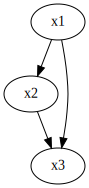

In [13]:
#Visualize the model
scm.cgm.draw()

In [14]:
from carla.models.catalog import MLModelCatalog

training_params = {"lr": 0.01, "epochs": 10, "batch_size": 16, "hidden_size": [18, 9, 3]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)


balance on test set 0.5278666666666667, balance on test set 0.5252
Epoch 0/9
----------
train Loss: 0.3921 Acc: 0.8313

test Loss: 0.3533 Acc: 0.8460

Epoch 1/9
----------
train Loss: 0.3694 Acc: 0.8361

test Loss: 0.3434 Acc: 0.8536

Epoch 2/9
----------
train Loss: 0.3661 Acc: 0.8377

test Loss: 0.3526 Acc: 0.8436

Epoch 3/9
----------
train Loss: 0.3625 Acc: 0.8364

test Loss: 0.3427 Acc: 0.8528

Epoch 4/9
----------
train Loss: 0.3643 Acc: 0.8377

test Loss: 0.3493 Acc: 0.8424

Epoch 5/9
----------
train Loss: 0.3626 Acc: 0.8399

test Loss: 0.3518 Acc: 0.8436

Epoch 6/9
----------
train Loss: 0.3614 Acc: 0.8401

test Loss: 0.3443 Acc: 0.8500

Epoch 7/9
----------
train Loss: 0.3617 Acc: 0.8380

test Loss: 0.3390 Acc: 0.8488

Epoch 8/9
----------
train Loss: 0.3596 Acc: 0.8388

test Loss: 0.3414 Acc: 0.8500

Epoch 9/9
----------
train Loss: 0.3592 Acc: 0.8416

test Loss: 0.3471 Acc: 0.8476



In [32]:
from carla.models.negative_instances import predict_negative_instances
# get factuals
factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:10].reset_index(drop=True)

print(test_factual)

   label        x1        x2        x3
0    0.0 -0.119061  0.253698 -0.604435
1    0.0  0.251406 -1.227722 -0.464812
2    0.0 -1.428555  0.418856  0.088319
3    0.0 -2.198140  2.342478 -1.665151
4    0.0 -1.042498  1.295428 -1.133146
5    0.0  1.693472 -0.478879 -1.673203
6    0.0  0.598839 -1.163336 -0.097240
7    0.0  1.261854 -0.480784 -1.574896
8    0.0 -2.265550  1.199628 -0.295670
9    0.0  0.831968 -2.233957  0.062286


In [33]:
from carla.recourse_methods.catalog.causal_recourse import (
    CausalRecourse,
    constraints,
    samplers,
)
hyperparams = {
    "optimization_approach": "brute_force",
    "num_samples": 10,
    "scm": scm,
    "constraint_handle": constraints.point_constraint,
    "sampler_handle": samplers.sample_true_m0,
}

# structural counterfactual (SCF)
cfs = CausalRecourse(ml_model, hyperparams).get_counterfactuals(test_factual)

output = cfs.reset_index(drop=True) - test_factual.loc[:,~test_factual.columns.isin(['label'])].reset_index(drop=True)
display(output)
display(cfs)

,x1,x2,x3
0,1.62116,0.03039,0.00000
1,0.00000,0.03039,0.00000
2,-0.69436,0.03039,1.05746
3,-0.69436,3.07480,0.00000
4,0.00000,3.07480,0.00000
5,0.00000,0.03039,0.00000
6,0.00000,0.03039,0.00000
7,1.62116,0.03039,0.00000
8,0.00000,3.07480,0.00000
9,0.00000,0.03039,0.00000


,x1,x2,x3
0,1.502099,0.284088,-0.604435
1,0.251406,-1.197332,-0.464812
2,-2.122915,0.449246,1.145779
3,-2.892500,5.417278,-1.665151
4,-1.042498,4.370228,-1.133146
5,1.693472,-0.448489,-1.673203
6,0.598839,-1.132946,-0.097240
7,2.883014,-0.450394,-1.574896
8,-2.265550,4.274428,-0.295670
9,0.831968,-2.203567,0.062286


In [34]:
import numpy as np
import importlib
from Semantic_Maningfullness import Sematic
importlib.reload(Semantic_Maningfullness)

mapping_dict={ 
      'u1': 'x1',
      'u2': 'x2',
      'u3': 'x3',
      }
results=[]
i=0

test_factual = test_factual.loc[:,~test_factual.columns.isin(['label'])]

for a in test_factual.index:

    if str(cfs.iloc[i]['x1'])=='nan':
        pass
    else:
        sem=Sematic(ml_model,scm,mapping_dict)
        try:
            res=sem.get_evaluation(test_factual.iloc[a],cfs.iloc[i])['semantic'][0]
            results.append( res)
        except: 
            pass
    i=i+1


cflabel [[0.89433897]]
factuals_label [[0.28501534]]
threshold [[0.86855874]]
predictions [[0.07585818]]
cflabel [[0.05005657]]
factuals_label [[0.04643472]]
threshold [[0.56381119]]
predictions [[0.07585818]]
cflabel [[0.19189228]]
factuals_label [[0.11540489]]
threshold [[0.20742178]]
predictions [[0.92414182]]
cflabel [[0.72449416]]
factuals_label [[0.02291907]]
threshold [[0.00338366]]
predictions [[0.92414182]]
cflabel [[0.97037154]]
factuals_label [[0.12537704]]
threshold [[0.4750045]]
predictions [[0.92414182]]
cflabel [[0.328817]]
factuals_label [[0.31458545]]
threshold [[0.46089458]]
predictions [[0.07585818]]
cflabel [[0.24975747]]
factuals_label [[0.23713697]]
threshold [[0.08821066]]
predictions [[0.07585818]]
cflabel [[0.8619701]]
factuals_label [[0.17405397]]
threshold [[0.50958299]]
predictions [[0.07585818]]
cflabel [[0.9232783]]
factuals_label [[0.04625325]]
threshold [[0.31854187]]
predictions [[0.92414182]]
cflabel [[0.09749815]]
factuals_label [[0.09428162]]
thresho

In [35]:
# Averaging of the reults
mean= np.mean(results)
std= np.std(results)
print(f'Semantic results {mean} +/- {std}')

Semantic results 0.6 +/- 0.48989794855663565


In [10]:
#TODO This is currently not workin 
# Building Probability Distribution of the output divided into complient/ not complient
import seaborn as sns 
import matplotlib.pyplot as plt 
# Data Distribution
id_comp= np.where(np.array(results)==1)
id_not_comp=np.where(np.array(results)==0)
print(id_not_comp)
if len(id_comp[0])==0:
    cfs_complient=[]
    cfs_complient_predict=[]
    
else:
    cfs_complient=cfs.iloc[id_comp[0]]
    cfs_complient_predict=np.max(ml_model.predict(np.array(cfs_complient.values).reshape(-1,cfs_complient.values.shape[-1])),axis=1)
cfs_not_complient=cfs.iloc[id_not_comp[0]]

print(cfs_not_complient)


# cfs_not_complient_predict=np.max(ml_model.predict(np.array(cfs_not_complient).reshape(-1,7)),axis=1)


(array([4]),)
         x2        x1        x3
4 -0.651673 -2.079584  1.510252


In [ ]:
#BoxPlot
import  numpy
from math import nan, isnan
cfs_complient_predict = [x for x in cfs_complient_predict if isnan(x) == False]
cfs_not_complient_predict = [x for x in cfs_not_complient_predict if isnan(x) == False]
cfs_complient_predict=np.array(cfs_complient_predict).reshape(-1)
cfs_not_complient_predict=np.array(cfs_not_complient_predict).reshape(-1)

print(cfs_not_complient_predict)
data = [cfs_complient_predict,cfs_not_complient_predict]

fig7, ax7 = plt.subplots()
ax7.set_title('Complient vs Not Complient')
ax7.boxplot(data)

#plt.ylim((0.99,1))
plt.show()